<style type="text/css">
.time_spent {
    width: 3em;
    border-style: none;
    background-color: silver;
    font-weight: bold;
    padding-left: 5px;
}
</style>

# Hochschule Bonn-Rhein-Sieg

# Mathematics for Robotics and Control, SS17

# Assignment 3 - Eigenfaces and Line Fitting

Let us first setup this notebook so that figures and plots can be shown in it.

In [103]:
try:
    shell = get_ipython()
    shell.enable_pylab("inline")
except NameError:
    pass

import numpy as np
import matplotlib.pyplot as plt
            
from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
import IPython


from PIL import Image
import scipy.misc  as msc
from scipy.spatial import distance

**Hint**: Before you start solving the assignment, you might want to check the following *numpy* functions:

```
PIL.Image.open
scipy.misc.imresize
scipy.spatial.distance
numpy.linalg.eigh
```

## Eigenfaces

Eigenvectors have many applications which are not limited to obtaining surface normals from a set of point clouds. In this assignment, you are asked to write your own facial recognition library. Take a look at the following image:

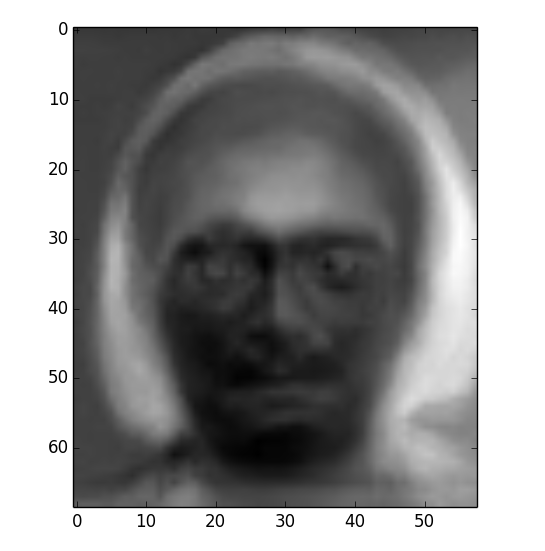

In [13]:
IPython.core.display.Image("images/ef0001.png")

This is what is called an *eigenface*. An eigenface really is nothing else than an eigenvector, in this case reshaped for plotting. Eigenfaces can be used in facial recognition, allowing a robot to distinguish between different persons, but can also be applied to other use cases, such as voice or gesture recognition.

**Your task consists of the following subtasks**:

1. Read the [Scholarpedia article](http://www.scholarpedia.org/article/Eigenfaces) about Eigenfaces. You can also read the [paper](http://www.face-rec.org/algorithms/PCA/jcn.pdf).
2. Implement the eigenface algorithm described in the article. In particular, create a Python class that exposes (at least) two methods:
    1. A method for calculating eigenfaces given two parameters, namely (i) a set of images and (ii) subject ids that uniquely identify the subjects in the images.
    2. A method that takes one parameter - a list of query faces - and, for each face in the input list, finds the subject id of the most similar face. This method should thus return a list of subject ids.

A dataset for training your recognition algorithm is given in the *data/training* folder. The images in the *data/test* folder should be used for testing the algorithm.

For your implementation, please use the method signatures given below. Use the code under **Testing your code** for loading the images and testing your implementation.

**Hint:** You might want to investigate how Principal Component Analysis (PCA) works.

In [122]:
class FaceRecognition(object):
    
    def eigenfaces(self, image_filenames, subject_ids):
        #Implement code here
        
        ##Getting list of Image Vectors
        image_array=[]
        
        while image_filenames:
            im = Image.open(image_filenames[0])
            image_matrix=(np.array(im))
            image_vector=image_matrix.flatten() #flattening the image matrix 
            image_array.append(image_vector.T)  #converting the image vector to a column vector and appending to array
            image_filenames.pop(0)
        
        D=image_array[0].size  #stores size of each image. i.e., h*w
        M=len(image_array)     #stores number of images
        
        ##Finding average face and difference of each image from the average face
        avg_face=np.zeros(D).T

        for j in range (0,D):
            
            for i in range (0,M):

                avg_face[j]=avg_face[j]+image_array[i][j]
        
        avg_face=avg_face/M
        self.avg=avg_face

        face_differ_phi=np.zeros(shape=(D,M))
        
        for i in range (0,M): 
            face_differ_phi[:,i]=(image_array[i]-avg_face) #difference of each image from the average face

        A=face_differ_phi

        ##Finding Eigen Faces
        
        ATA=A.T.dot(A)
        
        eigenvalues, eigenvectors = np.linalg.eigh(ATA)
        
        Lambda=diag(eigenvalues)
        Lambda[np.where(Lambda < 0)]=Lambda[np.where(Lambda < 0)]*(-1) 
        Lambda=np.linalg.inv(Lambda)**0.5
        
        self.U=A.dot(eigenvectors.dot(Lambda))   #This matrix stores the eigen faces of the training images
    
        UT=self.U.T
        
        self.Omega_training=UT.dot(face_differ_phi) 
        
        self.index=subject_ids               #This stores the indexes of the subjects.
      
        #raise NotImplementedError()
        
    def recognize_faces(self, image_filenames):
        
        ##Getting list of Image Vectors
        image_array=[]
        
        while image_filenames:
            im = Image.open(image_filenames[0])
            image_matrix=(np.array(im))
            image_vector=image_matrix.flatten() #flattening the image matrix 
            image_array.append(image_vector.T) #converting the image vector to a column vector and appending to array
            image_filenames.pop(0)
        
        D=image_array[0].size   #stores size of each image. i.e., h*w
        M=len(image_array)      #stores number of images
        
        ##Finding difference of each image from the average face
        
        face_differ_phi=np.zeros(shape=(D,M))
        avg_face=self.avg
        for i in range (0,M): 
            face_differ_phi[:,i]=(image_array[i]-avg_face)
        
        UT=self.U.T
        
        Omega=UT.dot(face_differ_phi)
        epsilon=[]
        for i in range (M):
           
            euclidean_dist=[]
            for j in range (self.Omega_training.shape[1]):
                euclidean_dist.append(np.linalg.norm(Omega[:,i]-self.Omega_training[:,j]))
            
            epsilon.append(euclidean_dist.index(min(euclidean_dist)))
        
        recognized_ids=[]
        for i in  range (M):
            recognized_ids.append(self.index[epsilon[i]])

        return recognized_ids  #This is of list datatype
        raise NotImplementedError()

        
    

# Testing your code

In [123]:
import os
import glob
import operator


#loading training images
training_image_filenames = sorted(glob.iglob('data/training/*.pgm'))

#loading test images
test_image_filenames = sorted(glob.iglob('data/test/*.pgm'))

#creating a lambda function for extracting filenames;
#the filename of each image is the subject id
subject_number = lambda filename: int(os.path.basename(filename)[7:9])

#extracting the filename using the lambda function
train_subject_ids = list (map(subject_number, training_image_filenames))
test_subject_ids = list (map(subject_number, test_image_filenames))

face_recognition = FaceRecognition()
face_recognition.eigenfaces(training_image_filenames, train_subject_ids)

recognized_ids = face_recognition.recognize_faces(test_image_filenames)

print "Recognized Ids:: \n", recognized_ids
print ""
different_results = np.array(test_subject_ids) - np.array(recognized_ids)
print "Different_results:: \n",different_results
print ""
positives = (different_results == 0).sum()
print "Positives: \n", positives


Recognized Ids:: 
[10, 1, 2, 1, 2, 3, 3, 14, 4, 4, 14, 4, 5, 5, 9, 5, 6, 6, 2, 6, 6, 7, 7, 7, 7, 8, 2, 8, 9, 9, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 13, 13, 14, 14, 4, 14, 15, 3, 15, 15, 15]

Different_results:: 
[ -9   0  -1   0   0   0   0 -11   0   0 -10   0   0   0  -4   0   0   0
   4   0   0   0   0   0   0   0   6   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0  10   0   0  12   0   0
   0]

Positives: 
46


## Line fitting

Assume that our robot captures the following point cloud using its Kinect sensor:

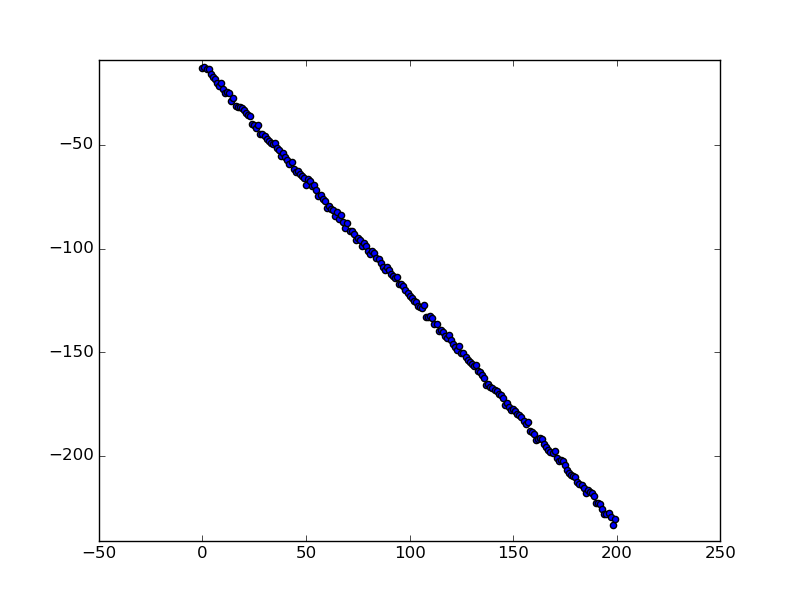

In [3]:
IPython.core.display.Image("images/points.png", embed=True)

Your task is to fit a line to the captured point cloud using SVD. The individual points of the point cloud are given in the file *data/points.npy*.

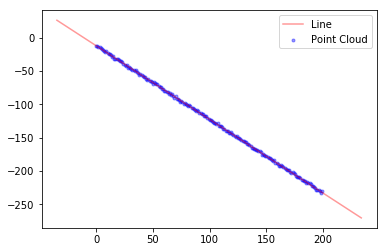

In [99]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d

def line_fit(data):
       
    mean=np.mean(data,axis=0) #getting the mean value of the dataset
    U,s,VT = np.linalg.svd(data-mean) #getting eigen vectors using svd of data-mean

    direction= VT[np.argmax(s)]/linalg.norm( VT[np.argmax(s)]) #getting direction normalized direction
                                                               #vector using the eigen vector
    #Taking two points to plot the line by scalling the vector with two scalars
    #The scaled vector is thens shifted by the mean to get the points in the same range as the point cloud
    
    Plt_points = np.array(mean + ((-200)*direction)) 
    Plt_points=np.vstack((Plt_points,np.array(mean + ((200)*direction))))
    
    plt.scatter(data[:,0],data[:,1], color='b', marker='.', alpha=.4, label='Point Cloud')
    plt.plot(Plt_points[:,0],Plt_points[:,1], color='r', alpha=.4, label='Line')
    plt.legend()
    plt.show()


point_cloud = np.load('data/points.npy')
line_fit(point_cloud)